In [111]:
import anndata
import scanpy as sc
import pandas as pd
import os

In [112]:
file_list = os.listdir('../data/GSE117498_RAW/')

# Filter to only include .tsv.gz files
file_list = [f for f in file_list if f.endswith('.tsv.gz')]

print(file_list)

['GSM3305362_PreBNK.raw_counts.tsv.gz', 'GSM3305360_MPP.raw_counts.tsv.gz', 'GSM3305368_LinNegCD34lowCD164high.raw_counts.tsv.gz', 'GSM3305364_CMP.raw_counts.tsv.gz', 'GSM3305359_HSC.raw_counts.tsv.gz', 'GSM3305369_LinNegCD34NegCD164low.raw_counts.tsv.gz', 'GSM3305366_LinNegCD34PosCD164Pos.raw_counts.tsv.gz', 'GSM3305361_MLP.raw_counts.tsv.gz', 'GSM3305363_MEP.raw_counts.tsv.gz', 'GSM3305367_LinNegCD34NegCD164high.raw_counts.tsv.gz', 'GSM3305365_GMP.raw_counts.tsv.gz']


In [113]:
metadata_file_path = "../data/HumanHematopoieticProgenitors_metadata_10-03-2022.xlsx"
metadata_cell_suspension = pd.read_excel(metadata_file_path, sheet_name= 6, skiprows = [0,1,2,4])
metadata_analysis_file = pd.read_excel(metadata_file_path, sheet_name= 13, skiprows = [0,1,2,4])

In [114]:
def import_counts_mtx(file_name):
    df = pd.read_csv('../data/GSE117498_RAW/' + file_name, sep = '\t', skiprows = [1], index_col = 0).T 
    adata = anndata.AnnData(X = df)
    print(f'{file_name} is complete.')
    return adata

In [115]:
def add_metadata(file_name, adata):
    adata.obs['GSM_ID'] = file_name[:10]

    matching_row = metadata_analysis_file[metadata_analysis_file['analysis_file.file_core.file_name'] == file_name]

    if not matching_row.empty:
        biomaterial_id = matching_row.iloc[0]['cell_suspension.biomaterial_core.biomaterial_id']
        adata.obs['biomaterial_id'] = biomaterial_id

    matching_row = metadata_cell_suspension[metadata_cell_suspension['cell_suspension.biomaterial_core.biomaterial_id'] == adata.obs['biomaterial_id'][0]]

    if not matching_row.empty:
        biomaterial_name = matching_row.iloc[0]['cell_suspension.biomaterial_core.biomaterial_name']
        adata.obs['biomaterial_name'] = biomaterial_name
    
    print(adata.obs.head(1))

    return adata

In [116]:
adatas = [import_counts_mtx(file_name) for file_name in file_list]

GSM3305362_PreBNK.raw_counts.tsv.gz is complete.
GSM3305360_MPP.raw_counts.tsv.gz is complete.
GSM3305368_LinNegCD34lowCD164high.raw_counts.tsv.gz is complete.
GSM3305364_CMP.raw_counts.tsv.gz is complete.
GSM3305359_HSC.raw_counts.tsv.gz is complete.
GSM3305369_LinNegCD34NegCD164low.raw_counts.tsv.gz is complete.
GSM3305366_LinNegCD34PosCD164Pos.raw_counts.tsv.gz is complete.
GSM3305361_MLP.raw_counts.tsv.gz is complete.
GSM3305363_MEP.raw_counts.tsv.gz is complete.
GSM3305367_LinNegCD34NegCD164high.raw_counts.tsv.gz is complete.
GSM3305365_GMP.raw_counts.tsv.gz is complete.


In [117]:
adatas = [add_metadata(file_name, adata) for file_name, adata in zip(file_list, adatas)]

                       GSM_ID biomaterial_id  \
AGTTGAAC-TTGCATAT  GSM3305362   SAMN09714395   

                                    biomaterial_name  
AGTTGAAC-TTGCATAT  PreB/NK (Donor A) cell suspension  
                       GSM_ID biomaterial_id               biomaterial_name
GGGAGATG-ATCCCACG  GSM3305360   SAMN09714397  MPP (Donor A) cell suspension
                       GSM_ID biomaterial_id  \
GGCTTTGC-CGCCTTGA  GSM3305368   SAMN09714389   

                                                 biomaterial_name  
GGCTTTGC-CGCCTTGA  Lin-CD34lowCD164high (Donor B) cell suspension  
                       GSM_ID biomaterial_id               biomaterial_name
AAGTGAGA-TGTAAAGG  GSM3305364   SAMN09714393  CMP (Donor A) cell suspension
                       GSM_ID biomaterial_id               biomaterial_name
AACAAATG-GGTCCCTT  GSM3305359   SAMN09714387  HSC (Donor A) cell suspension
                       GSM_ID biomaterial_id  \
GTGTCACC-AAATGTCG  GSM3305369   SAMN09714388   

       

/tmp/ipykernel_2111647/2492491351.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  matching_row = metadata_cell_suspension[metadata_cell_suspension['cell_suspension.biomaterial_core.biomaterial_id'] == adata.obs['biomaterial_id'][0]]
/tmp/ipykernel_2111647/2492491351.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  matching_row = metadata_cell_suspension[metadata_cell_suspension['cell_suspension.biomaterial_core.biomaterial_id'] == adata.obs['biomaterial_id'][0]]
/tmp/ipykernel_2111647/2492491351.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer ke

In [118]:
adata = sc.concat(adatas, index_unique='_', join = 'outer', fill_value = 0)

In [119]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], 
                           inplace=True, percent_top=[20], log1p=True)

In [120]:
adata.var

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
Barcode,,,,,,,,,
A1BG,False,False,False,92,0.004577,0.004566,99.570334,98,4.595120
A1BG-AS1,False,False,False,88,0.004764,0.004752,99.589016,102,4.634729
A1BG.AS1,False,False,False,125,0.006211,0.006192,99.416215,133,4.897840
A1CF,False,False,False,49,0.002288,0.002286,99.771156,49,3.912023
A2M,False,False,False,27,0.001354,0.001353,99.873902,29,3.401197
...,...,...,...,...,...,...,...,...,...
ZYG11B,False,False,False,1876,0.111433,0.105650,91.238558,2386,7.777793
ZYX,False,False,False,3811,0.259154,0.230440,82.201569,5549,8.621553
ZZEF1,False,False,False,1666,0.088315,0.084631,92.219316,1891,7.545390


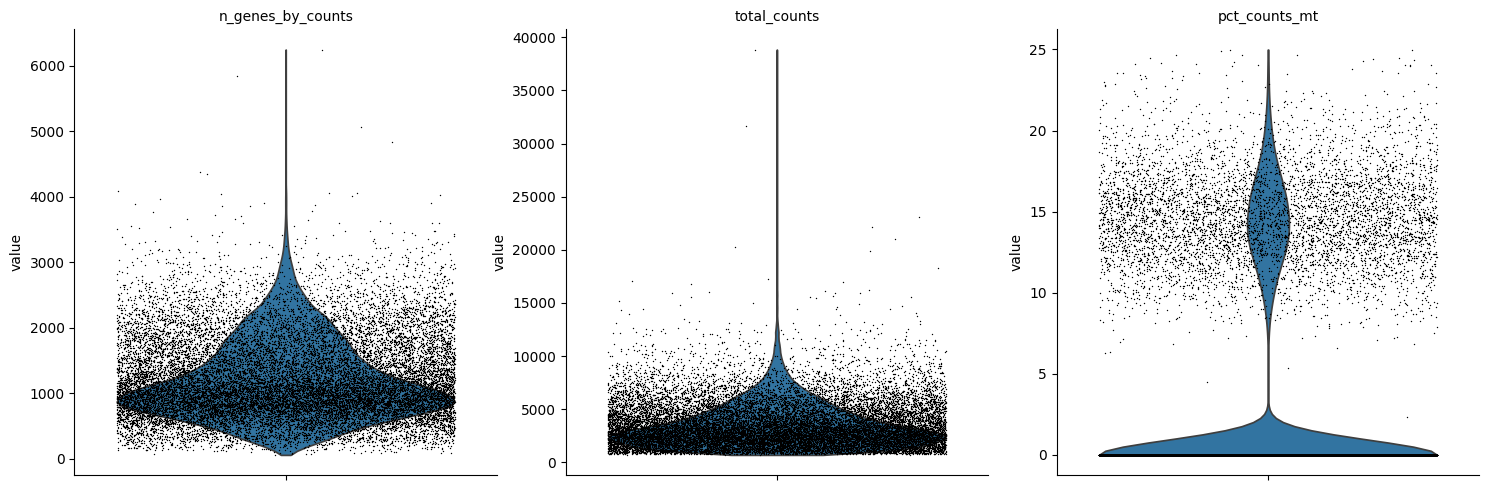

In [121]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [122]:
print(f"Total number of cells: {adata.n_obs}")
print(f"Total number of genes: {adata.n_vars}")
sc.pp.filter_genes(adata, min_cells=3)
print(f"Number of genes after cell filter: {adata.n_vars}")

print(f"Total number of cells: {adata.n_obs}")
sc.pp.filter_cells(adata, min_genes = 100)
print(f"Number of cells after gene filter: {adata.n_obs}")

Total number of cells: 21412
Total number of genes: 29601
Number of genes after cell filter: 24048
Total number of cells: 21412
Number of cells after gene filter: 21400


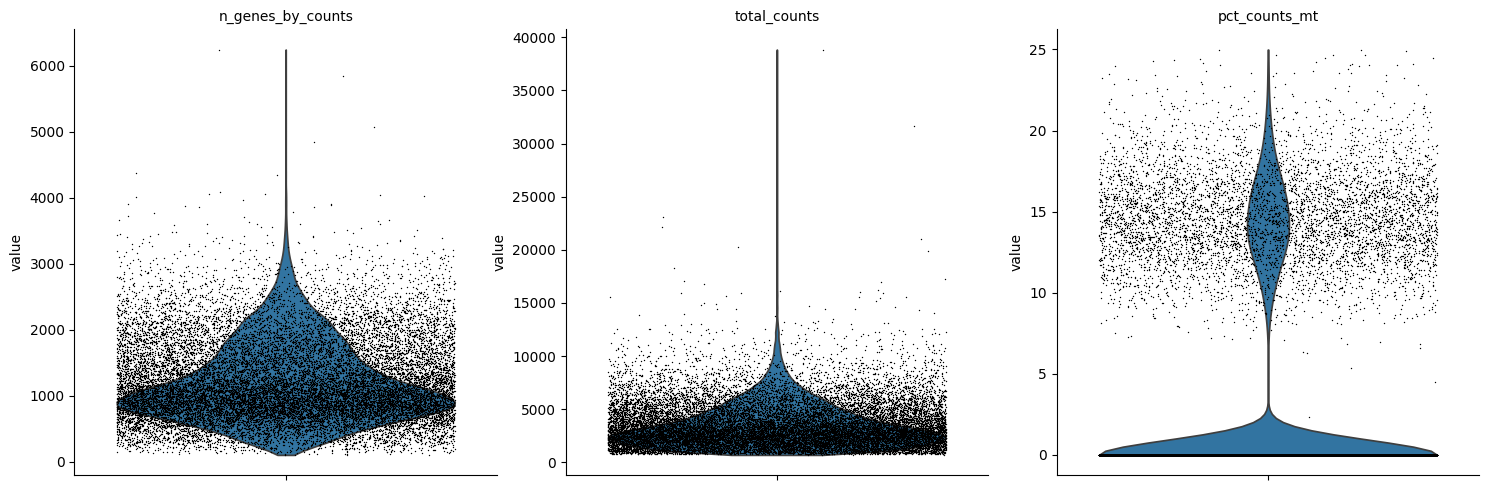

In [123]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [124]:
adata.layers['counts'] = adata.X.copy()

In [125]:

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [126]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, layer = 'counts',
                            flavor = 'seurat_v3', batch_key = 'GSM_ID', span = 0.5)

In [127]:
adata.var


,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
Barcode,,,,,,,,,,,,,,,,
A1BG.AS1,False,False,False,125,0.006211,0.006192,99.416215,133,4.897840,125,True,499.0,0.006215,0.006924,0.391006,1
A2M,False,False,False,27,0.001354,0.001353,99.873902,29,3.401197,27,True,238.0,0.001355,0.001634,0.914222,1
A4GALT,False,False,False,400,0.021763,0.021530,98.131889,466,6.146329,400,True,301.0,0.021776,0.028499,0.677449,1
AAGAB,False,False,False,1235,0.065944,0.063861,94.232206,1412,7.253470,1235,True,602.0,0.065981,0.084062,1.019704,1
ABCA13,False,False,False,237,0.013777,0.013683,98.893144,295,5.690359,237,True,570.5,0.013785,0.022194,1.119474,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN26,False,False,False,393,0.020362,0.020158,98.164581,436,6.079933,393,True,388.0,0.020374,0.028278,0.972247,1
ZSCAN29,False,False,False,938,0.052027,0.050719,95.619279,1114,7.016610,938,True,287.0,0.052056,0.076640,1.199917,3
ZSWIM3,False,False,False,140,0.006772,0.006749,99.346161,145,4.983607,140,True,565.0,0.006776,0.007197,0.890160,1


/mnt/gs21/scratch/islamsa3/fm-project/.conda/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


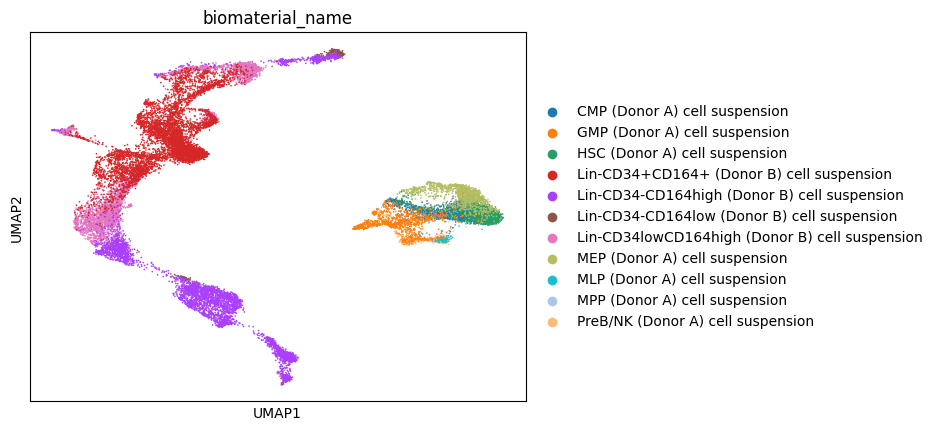

In [128]:
sc.pp.neighbors(adata, random_state = 0)
sc.tl.umap(adata, min_dist = 0.2)
sc.pl.umap(adata, color = "biomaterial_name")

In [129]:
biomaterial_names = adata.obs.biomaterial_name.unique()
for i in range(len(biomaterial_names)):
    print(biomaterial_names[i])

PreB/NK (Donor A) cell suspension
MPP (Donor A) cell suspension
Lin-CD34lowCD164high (Donor B) cell suspension
CMP (Donor A) cell suspension
HSC (Donor A) cell suspension
Lin-CD34-CD164low (Donor B) cell suspension
Lin-CD34+CD164+ (Donor B) cell suspension
MLP (Donor A) cell suspension
MEP (Donor A) cell suspension
Lin-CD34-CD164high (Donor B) cell suspension
GMP (Donor A) cell suspension


In [130]:
A_list = [biomaterial_names[i] for i in [0, 1, 3, 4, 7, 8, 10]]
B_list = [biomaterial_names[i] for i in [2, 5, 6, 9]]

In [131]:
adata_A = adata[adata.obs.biomaterial_name.isin(A_list)].copy()
adata_A

AnnData object with n_obs × n_vars = 6011 × 2000
    obs: 'GSM_ID', 'biomaterial_id', 'biomaterial_name', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'biomaterial_name_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

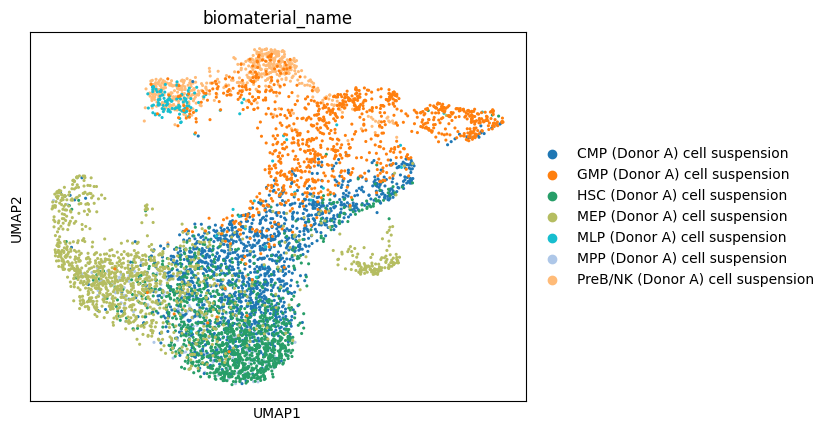

In [132]:
sc.pp.neighbors(adata_A, random_state = 0)
sc.tl.umap(adata_A, min_dist = 0.2)
sc.pl.umap(adata_A, color = 'biomaterial_name')

In [133]:
adata_B = adata[adata.obs.biomaterial_name.isin(B_list)].copy()
adata_B

AnnData object with n_obs × n_vars = 15389 × 2000
    obs: 'GSM_ID', 'biomaterial_id', 'biomaterial_name', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'biomaterial_name_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

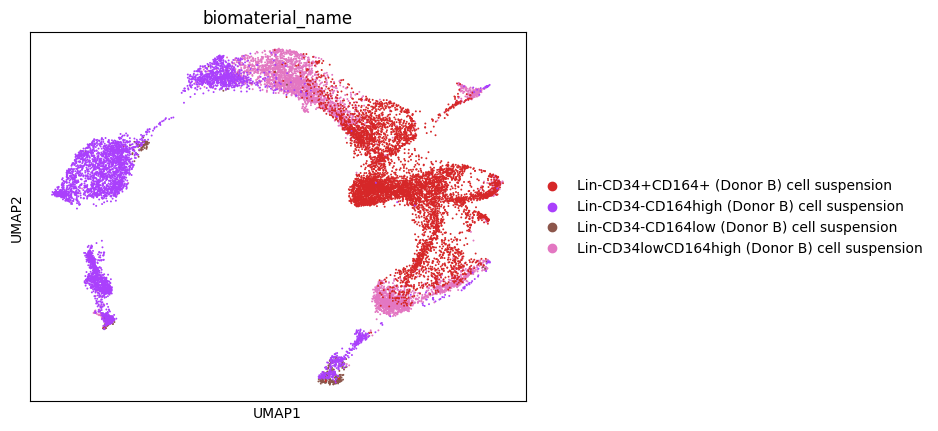

In [134]:
sc.pp.neighbors(adata_B, random_state = 0)
sc.tl.umap(adata_B, min_dist = 0.2)
sc.pl.umap(adata_B, color = 'biomaterial_name')

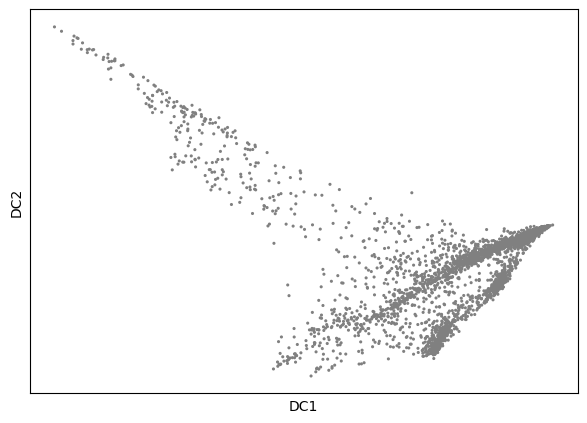

In [135]:
sc.tl.diffmap(adata_A)
sc.pl.scatter(adata_A, basis="diffmap")

In [136]:
adata_A.obsm["X_diffmap"][:, 1].argmax()

2164

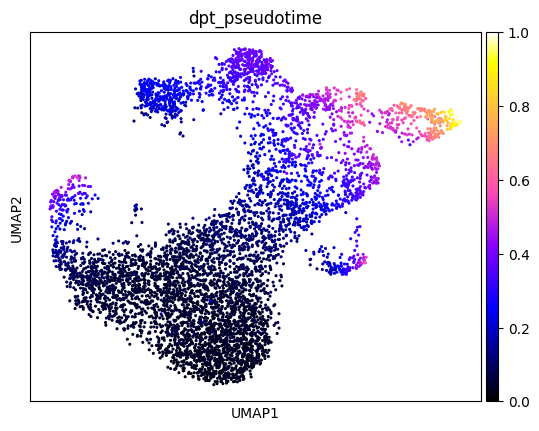

In [137]:
adata_A.uns['iroot'] = 2164
sc.tl.dpt(adata_A)
sc.pl.umap(adata_A, color="dpt_pseudotime", color_map="gnuplot2")

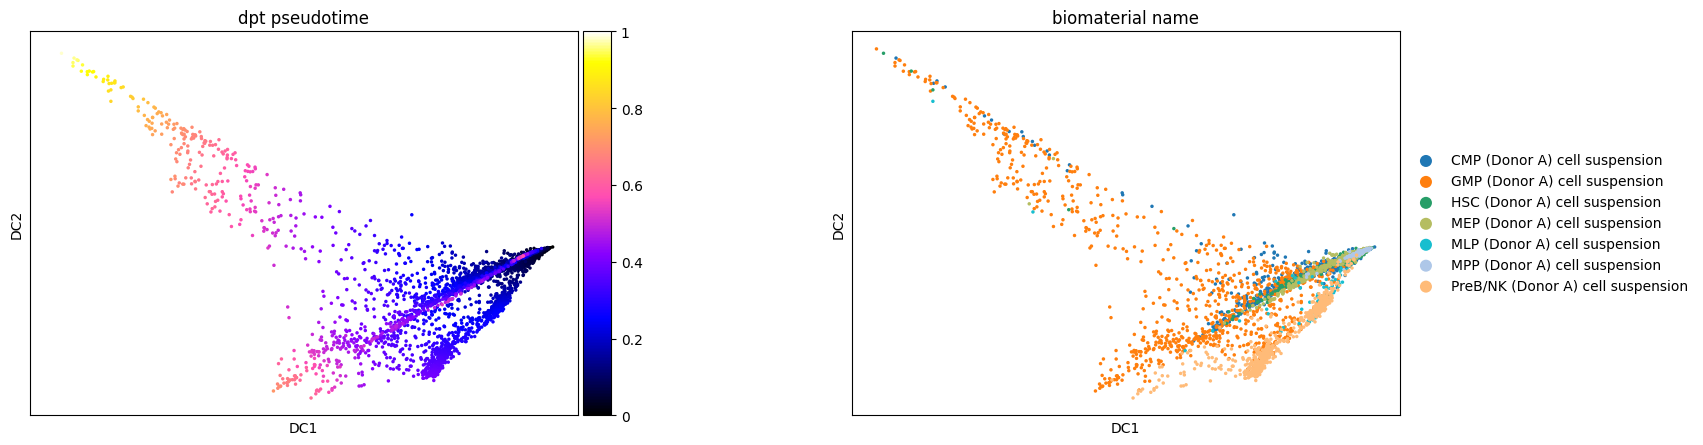

In [138]:

sc.pl.scatter(
    adata_A,
    basis="diffmap",
    color=["dpt_pseudotime", "biomaterial_name"],
    color_map="gnuplot2",
    size=25
)

In [139]:
cell_types_to_keep = ['HSC (Donor A) cell suspension', 'CMP (Donor A) cell suspension', 'GMP (Donor A) cell suspension']
adata_A = adata_A[adata_A.obs['biomaterial_name'].isin(cell_types_to_keep)].copy()

In [140]:
adata_A.obs['biomaterial_name'] = adata_A.obs['biomaterial_name'].str.split(' ').str[0]

In [141]:
adata_A.obs['cell_type'] = adata_A.obs['biomaterial_name']
del adata_A.obs['biomaterial_name']

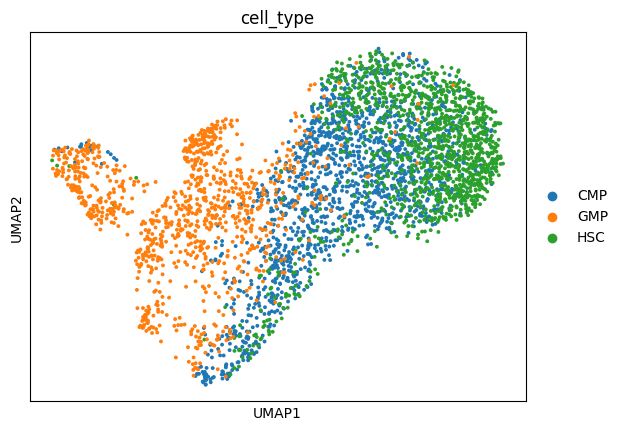

In [142]:
sc.pp.neighbors(adata_A, random_state = 0)
sc.tl.umap(adata_A, min_dist = 0.2)
sc.pl.umap(adata_A, color = 'cell_type')

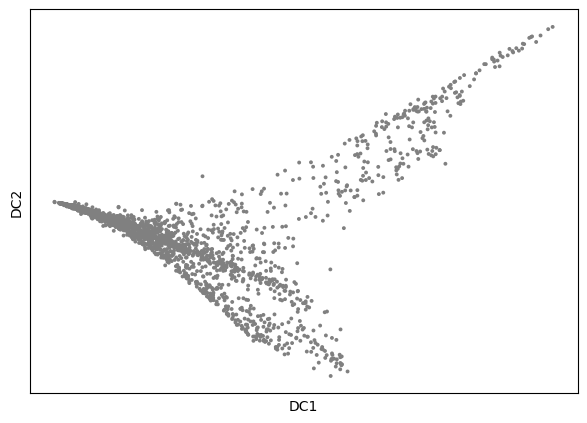

In [143]:
sc.tl.diffmap(adata_A)
sc.pl.scatter(adata_A, basis="diffmap")

In [144]:
adata_A.obsm["X_diffmap"][:, 1].argmin()

1782

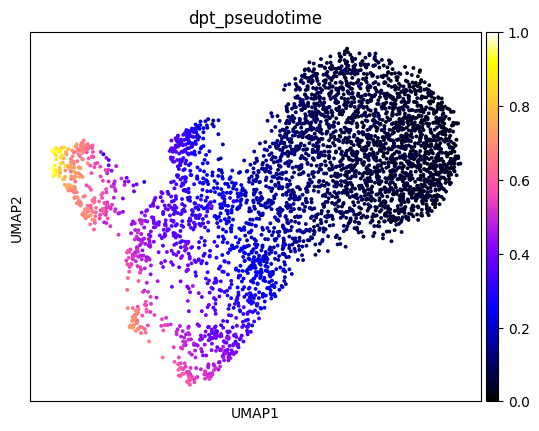

In [145]:
adata_A.uns['iroot'] = 1782
sc.tl.dpt(adata_A)
sc.pl.umap(adata_A, color="dpt_pseudotime", color_map="gnuplot2")

In [146]:
sorted_indices = adata_A.obs['dpt_pseudotime'].argsort()
adata_A = adata_A[sorted_indices].copy()

In [147]:
adata_A

AnnData object with n_obs × n_vars = 3870 × 2000
    obs: 'GSM_ID', 'biomaterial_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'dpt_pseudotime', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'biomaterial_name_colors', 'diffmap_evals', 'iroot', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [148]:
adata_A.write('../data/hematopoiesis.h5ad')